In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario, read_ontario_stations
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures

VIS_PATH = 'visualizations'
SMOOTH = 8 # -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
EPOCHS = 21
BATCH_SIZE = 32
ENC_SIZE = 8
FEATURE_SIZE = 16
POLLUTANTS = ['PM25', 'NO2'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32, 32]
CONV_KERNELS = [3, 3, 3]
UMAP_NEIGHBORS = 15


/home/texs/anaconda3/envs/cuml-torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Years case

In [2]:
windows_map = read_ontario(granularity='months')
pollutans = POLLUTANTS
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [3]:
# windows_map

In [4]:
month_ids = [date.month for date in dates]
year_ids = [date.year for date in dates]


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, len(month_ids) + 1)}
years_map = {int(year) : str(year) for year in year_ids}

In [5]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 4499, T: 28, D: 2 
(4499, 2, 28)


In [6]:
from source.featlearn.simclr import SimClrFL

encoder = SimClrFL(
    mts.D, 
    mts.T, 
    encoding_size = ENC_SIZE, 
    feature_size=FEATURE_SIZE, 
    filters = CONV_FILTERS,
    # kernels = [3, 3, 3],
    kernels = CONV_KERNELS,
    use_shape = True,
    # filters = [5, 5, 5],
)

encoder.fit(mts.X.transpose([0, 2, 1]), 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE)
mts.features = encoder.encode(mts.X.transpose([0, 2, 1]))
# mts.features = getContrastiveFeatures(
#     mts.X.transpose([0, 2, 1]), mts.y, 
#     epochs = EPOCHS, 
#     batch_size = BATCH_SIZE, 
#     loss_metric= LOSS, 
#     mode = MODE, 
#     encoding_size = ENC_SIZE,
#     conv_filters = CONV_FILTERS,
#     conv_kernels = CONV_KERNELS,
# )

Epoch[1] Train loss    avg: 2.0181189648648528
Epoch[10] Train loss    avg: 1.1708734027037384
Epoch[20] Train loss    avg: 1.1588693130100873


In [7]:
import umap

reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=UMAP_NEIGHBORS)
coords = reducer.fit_transform(mts.features)

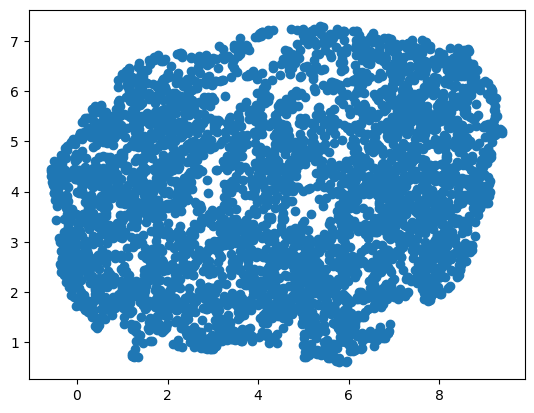

In [8]:
import matplotlib.pyplot as plt
plt.scatter(coords[:, 0], coords[:, 1])

In [9]:
from server.source.storage import MTSStorage

storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_years.npy'))    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    }
)


storage.save()

mts shape: N: 4499 -  T: 28 - D: 4
